In [122]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os
import matplotlib.pyplot as plt

In [123]:
trainImages = open(os.getcwd() + "/data/MINST/Fashion/train-images-idx3-ubyte", 'rb')
trainLabels = open(os.getcwd() + "/data/MINST/Fashion/train-labels-idx1-ubyte", 'rb')
testImages = open(os.getcwd() + "/data/MINST/Fashion/t10k-images-idx3-ubyte", 'rb')
testLabels = open(os.getcwd() + "/data/MINST/Fashion/t10k-labels-idx1-ubyte", 'rb')

In [124]:
assert(int.from_bytes(trainLabels.read(4), 'big') == 2049)
assert(int.from_bytes(trainImages.read(4), 'big') == 2051)
assert(int.from_bytes(testLabels.read(4), 'big') == 2049)
assert(int.from_bytes(testImages.read(4), 'big') == 2051)

In [125]:
X_train = np.zeros((int.from_bytes(trainImages.read(4), 'big'), int.from_bytes(trainImages.read(4), 'big'), int.from_bytes(trainImages.read(4), 'big')), dtype=np.float32)
Y_train = np.zeros((int.from_bytes(trainLabels.read(4), 'big'), 1), dtype=np.float32)

In [126]:
X_test = np.zeros((int.from_bytes(testImages.read(4), 'big'), int.from_bytes(testImages.read(4), 'big'), int.from_bytes(testImages.read(4), 'big')), dtype=np.float32)
Y_test = np.zeros((int.from_bytes(testLabels.read(4), 'big'), 1), dtype=np.float32)

In [127]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 28, 28)
(60000, 1)
(10000, 28, 28)
(10000, 1)


In [128]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            X_train[i,j,k] = float(int.from_bytes(trainImages.read(1), 'big'))
    Y_train[i] = float(int.from_bytes(trainLabels.read(1), 'big'))

for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        for k in range(X_test.shape[2]):
            X_test[i,j,k] = float(int.from_bytes(testImages.read(1), 'big'))
    Y_test[i] = float(int.from_bytes(testLabels.read(1), 'big'))

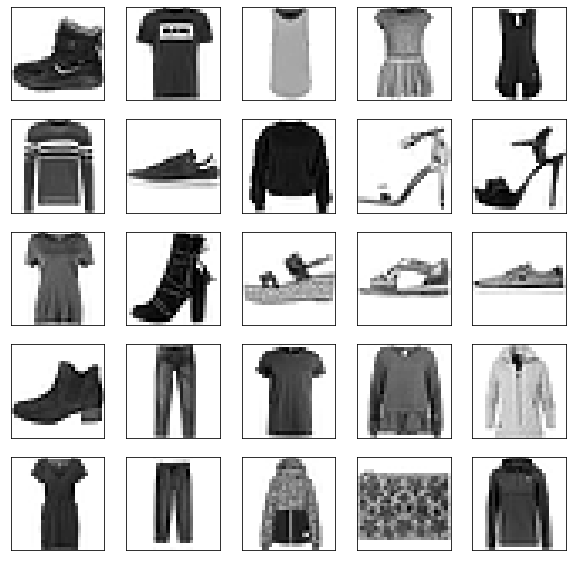

In [129]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

In [130]:
X_train = tf.convert_to_tensor(X_train,dtype=tf.float32)/255
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)/255

In [131]:
X_train = tf.reshape(X_train, shape=(X_train.shape[0], 28,28,1))
X_test = tf.reshape(X_test, shape=(X_test.shape[0], 28,28,1))
X_train.shape, X_test.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [132]:
Y_train = tf.keras.utils.to_categorical(Y_train,num_classes=10)
Y_test = tf.keras.utils.to_categorical(Y_test,num_classes=10)

In [133]:
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

In [134]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [135]:
def convModel(input_shape):
    XIn = keras.Input(shape=input_shape)

    X = keras.layers.Convolution2D(100, 3, strides=(1,1), padding='same', data_format='channels_last',input_shape=input_shape, activation='relu', name='Conv0')(XIn)
    X = keras.layers.Convolution2D(200,3, activation='relu', name='Conv1')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2),name='P0')(X)
    X = keras.layers.BatchNormalization(name='B0')(X)

    X = tf.keras.layers.Dropout(0.2)(X)

    X = keras.layers.Convolution2D(300, 3, name='Conv2',activation='relu')(X)
    X = keras.layers.MaxPool2D(name='P1')(X)
    X = keras.layers.BatchNormalization(name='B2')(X)

    X= keras.layers.Flatten()(X)

    X = tf.keras.layers.Dropout(0.2)(X)

    X = keras.layers.Dense(500,activation='relu', name='FC3')(X)

    X = keras.layers.Dense(10,activation='softmax', name='FC4')(X)

    model = tf.keras.Model(inputs=XIn, outputs= X)

    return model

In [136]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=0,min_delta=0.0001)

In [137]:
model1 = convModel(X_train.shape[1:])
model1.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv0 (Conv2D)               (None, 28, 28, 100)       1000      
_________________________________________________________________
Conv1 (Conv2D)               (None, 26, 26, 200)       180200    
_________________________________________________________________
P0 (MaxPooling2D)            (None, 13, 13, 200)       0         
_________________________________________________________________
B0 (BatchNormalization)      (None, 13, 13, 200)       800       
_________________________________________________________________
dropout_37 (Dropout)         (None, 13, 13, 200)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 11, 11, 300)       540

In [138]:
model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [139]:
history = model1.fit(X_train,Y_train, epochs=50,batch_size=100, validation_data=(X_test, Y_test),validation_freq=1, callbacks=[earlystop_callback])

Epoch 1/50
600/600 [==============================] - 18s 29ms/step - loss: 0.4509 - accuracy: 0.8517
Epoch 2/50
600/600 [==============================] - 18s 30ms/step - loss: 0.2578 - accuracy: 0.9063
Epoch 3/50
600/600 [==============================] - 19s 32ms/step - loss: 0.2102 - accuracy: 0.9229 - val_loss: 0.3497 - val_accuracy: 0.8834
Epoch 4/50
600/600 [==============================] - 18s 31ms/step - loss: 0.1840 - accuracy: 0.9319
Epoch 5/50
600/600 [==============================] - 18s 30ms/step - loss: 0.1622 - accuracy: 0.9383
Epoch 6/50
600/600 [==============================] - 19s 32ms/step - loss: 0.1378 - accuracy: 0.9492 - val_loss: 0.3362 - val_accuracy: 0.9026
Epoch 7/50
600/600 [==============================] - 18s 30ms/step - loss: 0.1156 - accuracy: 0.9570
Epoch 8/50
600/600 [==============================] - 18s 30ms/step - loss: 0.1007 - accuracy: 0.9627
Epoch 9/50
600/600 [==============================] - 19s 32ms/step - loss: 0.0920 - accuracy: 0.965

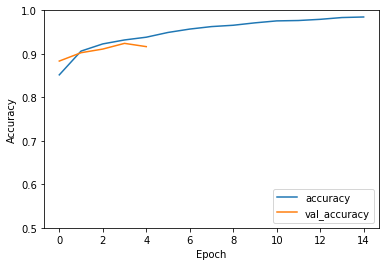

In [140]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

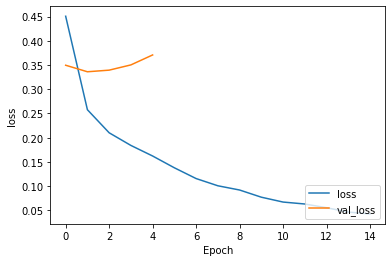

In [141]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

In [142]:
model1.evaluate(X_test,Y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.3709 - accuracy: 0.9166


[0.3709281384944916, 0.9165999889373779]